# Tornado Synthetic Dataset - 3D Steady
> [cgl datasets](https://cgl.ethz.ch/research/visualization/data.php)

In [133]:
import numpy as np
import pyvista as pv

In [134]:
file = '..\\Data\\tornado3d.vti'
mesh = pv.read(file)

In [135]:
w,v,u = mesh.point_data['w'], mesh.point_data['v'], mesh.point_data['u']

vectors = np.empty((mesh.n_points, 3))
vectors[:,0] = u
vectors[:,1] = v
vectors[:,2] = w

mesh['vectors'] = vectors


In [136]:
# Sphere Source
stream1, seed_pts = mesh.streamlines(
    'vectors', 
    return_source=True,
    n_points=1,
    source_radius=0,
    source_center=(-4e-11,-4e-11,-4e-11),
    integration_direction='forward'
)

In [137]:
s = 2

w2,v2,u2 = mesh.point_data['w'], mesh.point_data['v'], mesh.point_data['u']

u2.shape = v2.shape = w2.shape = mesh.dimensions


# Down Sample / Decimate
u2 = u2[::s, ::s, ::s] 
v2 = v2[::s, ::s, ::s]
w2 = w2[::s, ::s, ::s]

dims = u2.shape

# Flatten vectors
# u2 = u2.flatten(order='F')
# v2 = v2.flatten(order='F')
# w2 = w2.flatten(order='F')

u2 = u2.flatten()
v2 = v2.flatten()
w2 = w2.flatten()

vectors2 = np.empty((int(len(u2)), 3))
vectors2[:,0] = u2
vectors2[:,1] = v2
vectors2[:,2] = w2

mesh2 = pv.UniformGrid(
    dims=dims,
    spacing=tuple([x*s for x in list(mesh.spacing)]),
    origin=mesh.origin
)

mesh2['vectors2'] = vectors2


In [138]:
stream2 = mesh2.streamlines_from_source(
    vectors='vectors2', 
    source=seed_pts,
    integration_direction='forward'
)

In [139]:
a = 0

print(stream1.cell_points(a)[0,:])
print(stream2.cell_points(a)[0,:])

p = pv.Plotter()
p.add_mesh(stream1.cell_points(a), color='red')
p.add_mesh(stream2.cell_points(a), color='blue')
p.show()

[-3.99999998e-11 -3.99999998e-11 -3.99999998e-11]
[-3.99999998e-11 -3.99999998e-11 -3.99999998e-11]


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [140]:
from scipy import interpolate

errors = []
for i in range(stream1.n_cells):
    print(i)
    stream_1 = stream1.cell_points(i).copy()
    stream_2 = stream2.cell_points(i).copy()
    
    # Distance between each point in streamline
    dv_1 = stream_1[1:,:] - stream_1[:-1,:]
    dv_2 = stream_2[1:,:] - stream_2[:-1,:]
    
    # Length / Magnitude of each delta t
    dl_1 = np.sqrt(np.sum(dv_1**2, axis=1))
    dl_2 = np.sqrt(np.sum(dv_2**2, axis=1))
    
    t1 = np.r_[0, np.cumsum(dl_1)]
    t2 = np.r_[0, np.cumsum(dl_2)]
   
    # Lengths of streamline
    length_1 = t1[-1]
    length_2 = t2[-1]
    
    print(length_1)
    print(length_2)
    
    x1 = interpolate.interp1d(t1, stream_1[:,0])
    y1 = interpolate.interp1d(t1, stream_1[:,1])
    z1 = interpolate.interp1d(t1, stream_1[:,2])
    p1 = lambda t : np.c_[x1(t), y1(t), z1(t)]
    
    x2 = interpolate.interp1d(t2, stream_2[:,0])
    y2 = interpolate.interp1d(t2, stream_2[:,1])
    z2 = interpolate.interp1d(t2, stream_2[:,2])
    p2 = lambda t : np.c_[x2(t), y2(t), z2(t)]
    
    t = np.linspace(0, min(length_1, length_2), 11)    
    ind_error = np.linalg.norm(p1(t) - p2(t), axis=1) # Same as magnitude
    tot_error = np.sum(ind_error)
    rms_error = np.sqrt(np.mean(ind_error**2))
    # print(ind_error.shape)

    errors.append(ind_error)

0


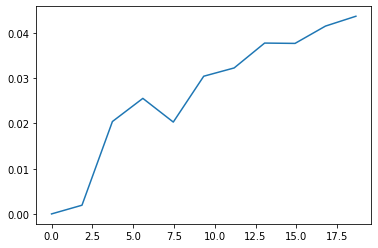

In [141]:
import matplotlib.pyplot as plt
for i in range(len(errors)):
    plt.plot(t, errors[i], label="error {i}")
# plt.legend()
plt.show()